In [1]:
import numpy as np
import random
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline  

from timeit import default_timer as timer

import scipy
from scipy import spatial as sp

from theano import function, config, shared, sandbox
import theano.tensor as T

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)


In [2]:
def generate_mixture(n_points):
    ''' Generate a dataset with 2D n_points as a mixture'''
    X = np.concatenate([np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], n_points),
                        np.random.multivariate_normal([8,6], [[2, 0], [0, 2]], n_points), 
                        np.random.multivariate_normal([4,2], [[1, 0.2], [0.2, 0.5]], n_points)])
    return(X)

In [3]:
X = generate_mixture(50)

centers1 = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), 1)])
centers2 = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), 1)])
centers3 = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), 1)])

# Numpy

In [4]:
def kmeans(X, k, max_iter=100, epsilon = 0.01):
    # Initialize from random points.
    centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), k)])
    cluster = [None] * np.shape(X)[0]
    old_centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), k)]) #beware !
    ''' Beware : a better initialization ?'''
    
    n_iter = 1
 
    while (n_iter <= max_iter) & (np.linalg.norm(centers - old_centers) > epsilon):
        for i, x in enumerate(X):
            cluster[i] = min(range(k), key=lambda j: np.linalg.norm(np.array(x) - np.array(centers[j])))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if cluster[i] == j]
            old_centers = centers.copy()
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
            
        n_iter += 1    
    return cluster, np.array(centers), n_iter


## Test with Numpy

In [5]:
n_points = 40000
n_clusters = 3
max_iter = 20

X = generate_mixture(n_points)

Kmeans with 40000 points and 3 clusters with 3 iterations on CPU in 5.507772 s


(-5, 15)

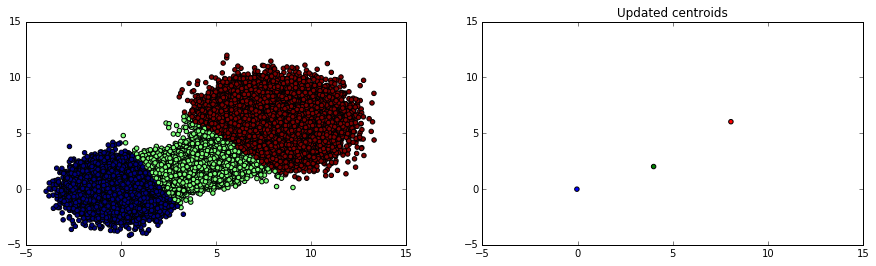

In [6]:
start = timer()
cluster, centers, n_iter = kmeans(X, n_clusters, max_iter, 0.1)
dt = timer() - start
print("Kmeans with %.0f points and %.0f clusters with %.0f iterations on CPU in %f s" % (n_points, n_clusters, n_iter-1, dt))

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c = cluster)
plt.xlim([-5, 15])
plt.ylim([-5, 15])

plt.subplot(1, 2, 2)
plt.title('Updated centroids')
plt.scatter(centers[:, 0], centers[:, 1], c = 'bgr')
plt.xlim([-5, 15])
plt.ylim([-5, 15])


# Theano

In [7]:
def kmeans_theano(X, k, max_iter=100):
    # Initialize from random points.
    centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), k)])
    cluster = [None] * np.shape(X)[0]
    old_centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), k)]) #beware !
    ''' Beware : a better initialization ?'''
    
    n_iter = 1
    import scipy
    from scipy import spatial as sp
    while (n_iter <= max_iter) & (np.linalg.norm(centers - old_centers) > epsilon):
        for i, x in enumerate(X):
            cluster[i] = min(range(k), key=lambda j: np.linalg.norm(np.array(x) - np.array(centers[j])))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if cluster[i] == j]
            old_centers = centers.copy()
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
            
        n_iter += 1    
    return cluster, np.array(centers), n_iter


In [8]:
import theano
from theano import tensor as T
import numpy as np

def floatX(X):
    return np.asarray(X, dtype = theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def model(X,w):
    return T.nnet.softmax(T.dot(X,w))

X = T.fmatrix()
Y = T.fmatrix()

w = init_weights((784, 10))

py_x = model(X,w)
y_pred = T.argmax(py_x, axis = 1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
gradient = T.grad(cost = cost, wrt = w)
update = [[w, w - 0.05 * gradient]]

train = theano.function(inputs = [X,Y], outputs = cost, 
                        updates = update)

predict = theano.function(inputs=[X], outputs = y_pred)



In [9]:
import theano
from theano import tensor as T

# Generate some data
X = generate_mixture(n_points)

# Initialize the centroids
def init_centroids(X, n_clusters):
    return theano.shared(floatX(np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), n_clusters)])))

centroids = init_centroids(X, n_clusters)

# Initialize the clusters
def get_clusters(X, centroids):
    distance_point_centroids = theano.shared(floatX())

print(centroids.get_value())
cost = T.mean(T.square(X-centroids))





[[-0.64073676 -1.20439279]
 [ 4.35409069  1.6008271 ]
 [ 5.6807394   3.20413065]]


In [10]:
centroids.get_value()[0,:]

array([-0.64073676, -1.20439279], dtype=float32)

In [11]:
ccc = floatX(np.linalg.norm(X[0] - centroids.get_value(), axis=1))
#get_cluster = theano.function([X, centroids], ccc)
ccc

array([ 1.89460039,  6.01077795,  7.73167229], dtype=float32)

### with gradient descent

In [12]:
import theano
from theano import tensor as T

# Generate some data
X = generate_mixture(n_points)

# Initialize the centroids
def init_centroids(n_points):
    return theano.shared(floatX(np.random.randn(n_points, 2)))

centroids = init_centroids(n_points)
print(centroids.get_value())

#cost = T.

[[ 0.09741695  0.02438122]
 [ 0.87981826 -1.27899063]
 [ 2.89693189 -0.24149595]
 ..., 
 [ 0.53757399  0.65308505]
 [ 0.35654452  1.32803917]
 [ 0.79375738 -0.75974733]]


In [13]:
import theano
from theano import tensor as T
import numpy as np
import random
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline  

from timeit import default_timer as timer

In [14]:
def kmeans_theano(data, n_clusters, alpha, epochs = 100, batch = 1, verbose = False, epsilon = 0.1):   
    
    # Dimensions of the problem
    n_points, n_dim = data.shape
    
    # Symmbol variables
    Z = T.dmatrix('Z')
    W = T.dmatrix('W')
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim), name="centroids")
    
    
    # Find winner unit
    bmu = T.argmin(T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), axis = 0)
    dist = T.dot(W.T, Z) - T.mul(T.sum(W,axis = 0)[:,None], centroids)
    err = T.sum(T.square(dist))
    
    update = theano.function([Z,W],outputs=err,updates=[(centroids, centroids + alpha * dist)], mode="FAST_RUN")
    find_bmu = theano.function([Z], bmu) #mode="FAST_RUN")
       
    # Update
    for epoch in range(epochs):
        C = 0
        for i in range(0, n_points, batch):
            D = find_bmu(data[i:i+batch, :])
            #theano.printing.debugprint(find_bmu)
            S = np.zeros([batch,n_clusters])
            S[range(batch),D] = 1
            cost = update(data[i:i+batch, :], S)
            
        if epoch%10 == 0 and verbose:
            print( "Avg. centroid distance -- ", cost.sum(),"\t EPOCH : ", epoch)


    return centroids.get_value()

In [15]:
from sklearn import datasets

# Test Codes
blobs = datasets.make_blobs(n_samples=4000, random_state=8)

DATA =blobs[0]

** Warning batch size must be able to divide the number of points**

In [16]:
import time
t1 = time.time()
# number of points must be a multiple of batch size otherwise won't work
W = kmeans_theano(DATA ,3,alpha = 0.001, epochs=100, batch=2000, verbose=False, epsilon = 0.1)
t2 = time.time()

Kmeans with Theano : 0.211 s.


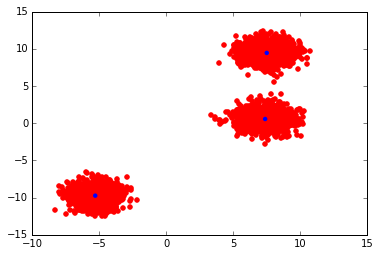

In [17]:
print("Kmeans with Theano : %.3f s." %(t2-t1))

plt.scatter(DATA[:,0], DATA[:,1], color='red')
plt.scatter(W[:,0],W[:,1],color='blue',s=20,edgecolor='none')

In [20]:
def getClusters_id(dataSet,centroids,k):
    """
    Returns an array of scalars (1:k) of dimension nb_points.
    """
    clusters= [None]*np.shape(dataSet)[0] #np.zeros((1,np.shape(dataSet)[1]))
    for i,x in enumerate(dataSet):
        clusters[i] = min(range(k), key=lambda j: np.sqrt(((dataSet[i]-centroids[j])**2).sum(axis=0)))
    return clusters

Kmeans with Theano : 0.211 s.


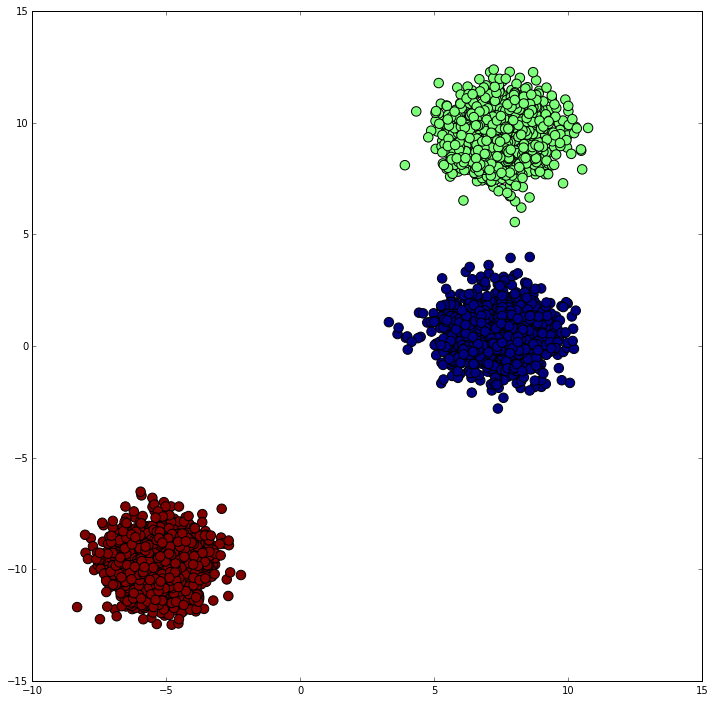

In [22]:
print("Kmeans with Theano : %.3f s." %(t2-t1))
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(DATA[:,0], DATA[:,1],c=getClusters_id(DATA,W,3),s=90)

## Test on pictures segmentation

Sample size : [276480, 3]


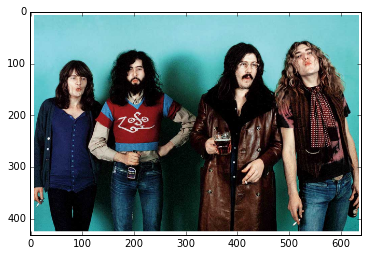

In [23]:
image = scipy.misc.imread('../data/images/orig.png')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
samples = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])
print('Sample size : %s' %(list(np.shape(samples))) )

In [24]:
%%time
centroids = kmeans_theano(samples,6,alpha = 0.0001, epochs=100, batch=1080, verbose=False, epsilon = 0.01)
#alpha must be really small for good results alpha = 0.0001

CPU times: user 6.1 s, sys: 232 ms, total: 6.33 s
Wall time: 6.26 s


In [27]:
def getLabels(dataSet, centroids):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    #method which avoids loops with scipy cdist function
    dist_mat=cydist(dataSet,centroids)
    #dist_mat=sp.distance.cdist(dataSet,centroids,metric="euclidean")
    min_idx=dist_mat.argmin(axis=1) #vector of minimum index for each row
    mat=centroids[min_idx]
    return mat

def cydist(a, b):
    dims = a.shape[1]
    rows = a.shape[0]
    cols = b.shape[0]
    out = np.zeros((rows,cols)) 
    for dim in range(dims):
        out += np.subtract.outer(a[:,dim], b[:,dim])**2
    return out

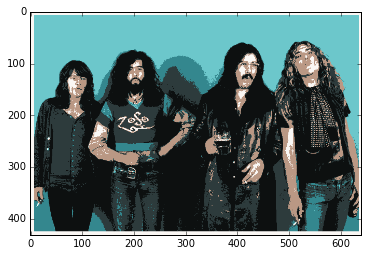

In [28]:
segmented=getLabels(samples,centroids).astype(np.uint8)
reconstruct = np.array(segmented).reshape((w,h, 3))
plt.imshow(reconstruct)

### Version Ergodol

In [29]:
import theano
import theano.tensor as T
from theano import function, config, shared, sandbox
from theano import ProfileMode
import warnings
warnings.filterwarnings("ignore")

# Dummy Data

def create_dummy_data( N=4000, feats=784):
    rng = np.random
    DATA = rng.randn(N, feats)
    DATA = np.random.randn(N, feats)
    return DATA

def klp_kmeans(data, cluster_num, alpha, epochs = -1, batch = 1, verbose = False, use_gpu=False):   
	'''
		Theano based implementation, likely to use GPU as well with required Theano
		configurations. Refer to http://deeplearning.net/software/theano/tutorial/using_gpu.html
		for GPU settings
		Inputs:
			data - [instances x variables] matrix of the data.
			cluster_num - number of requisite clusters 
			alpha - learning rate 
			epoch - how many epoch you want to go on clustering. If not given, it is set with
				Kohonen's suggestion 500 * #instances
			batch - batch size. Larger batch size is better for Theano and GPU utilization 
			verbose - True if you want to verbose the algorithm's iterations
		Output:
			W - final cluster centroids
	'''
	if use_gpu:
		config.floatX = 'float32' # Theano needs this type of data for GPU use

	warnings.simplefilter("ignore", DeprecationWarning)
	warnings.filterwarnings("ignore")

	rng = np.random
    # From Kohonen's paper
	if epochs == -1:
	    print data.shape[0]
	    epochs = 500 * data.shape[0]

	
	if use_gpu == False:
		# Symmbol variables
		X = T.dmatrix('X')
		WIN = T.dmatrix('WIN')

		# Init weights random
		W = theano.shared(rng.randn(cluster_num, data.shape[1]), name="W")
	else:
		# for GPU use 
		X = T.matrix('X')
		WIN = T.matrix('WIN')
		W = theano.shared(rng.randn(cluster_num, data.shape[1]).astype(theano.config.floatX), name="W")

	W_old = W.get_value()

	# Find winner unit
	bmu = ((W**2).sum(axis=1, keepdims=True) + (X**2).sum(axis=1, keepdims=True).T - 2*T.dot(W, X.T)).argmin(axis=0)
	dist = T.dot(WIN.T, X) - WIN.sum(0)[:, None] * W
	err = abs(dist).sum()/X.shape[0]

	update = function([X,WIN],outputs=err,updates=[(W, W + alpha * dist)], allow_input_downcast=True)
	find_bmu = function([X], bmu, allow_input_downcast=True)

	if any([x.op.__class__.__name__ in ['Gemv', 'CGemv', 'Gemm', 'CGemm'] for x in
	        update.maker.fgraph.toposort()]):
	    print 'Used the cpu'
	elif any([x.op.__class__.__name__ in ['GpuGemm', 'GpuGemv'] for x in
	        update.maker.fgraph.toposort()]):
	    print 'Used the gpu'
	else:
	    print 'ERROR, not able to tell if theano used the cpu or the gpu'
	    print update.maker.fgraph.toposort()
    
    
	# Update
	for epoch in range(epochs):
	    C = 0
	    for i in range(0, data.shape[0], batch):
	    	batch_data = data[i:i+batch, :]
	        D = find_bmu(batch_data)
	        # for GPU use 
	        if use_gpu:
	        	S = np.zeros([batch,cluster_num], config.floatX)
	        else:
	        	S = np.zeros([batch_data.shape[0],cluster_num])
	        S[:,D] = 1
	        cost = update(batch_data, S)
	        
	    if epoch%10 == 0 and verbose:
	        print "Avg. centroid distance -- ", cost.sum(),"\t EPOCH : ", epoch
	return W.get_value()

In [30]:
%time W=klp_kmeans(DATA, 3, alpha = 0.00001, epochs = 100, batch = 2000, verbose = False, use_gpu=True)

Used the gpu
CPU times: user 528 ms, sys: 88 ms, total: 616 ms
Wall time: 614 ms


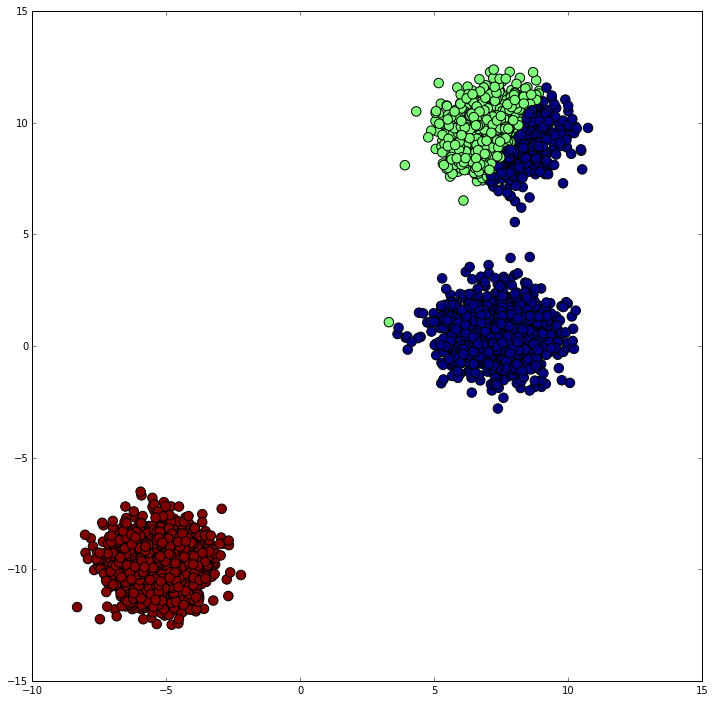

In [31]:
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(DATA[:,0], DATA[:,1],c=getClusters_id(DATA,W,3),s=90)

In [32]:
%time W= klp_kmeans(DATA, 3, alpha = 0.0001, epochs = 100, batch = 2000, verbose = False, use_gpu=False)

Used the cpu
CPU times: user 712 ms, sys: 0 ns, total: 712 ms
Wall time: 712 ms


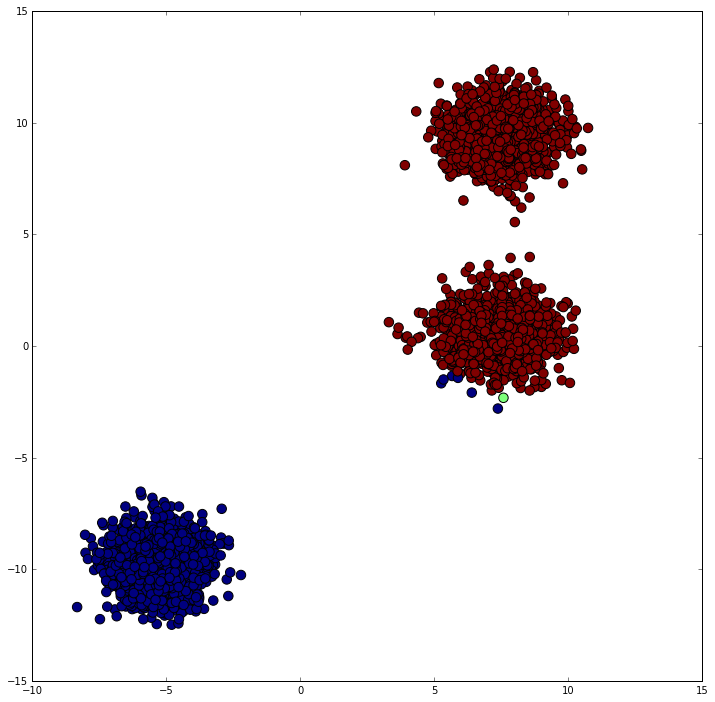

In [33]:
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(DATA[:,0], DATA[:,1],c=getClusters_id(DATA,W,3),s=90)